# Plot Renewable Suitability Maps

This notebook provides the code to plot the renewable suitability maps for solar and wind.

In [2]:
import os
import glob

import yaml
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

from matplotlib.colors import ListedColormap
import matplotlib as mpl
import matplotlib.patches as mpatches

In [4]:
# set year of analysis
year = 2050

# data dir
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'input_data')

# output data dir
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'output_data')

# figure dir
figure_dir = os.path.join(os.path.dirname(os.getcwd()), 'figures', 'suitability_maps')

# raster dir
raster_dir = os.path.join(data_dir, 'raster_data')

# state raster path
state_raster_path = os.path.join(raster_dir, 'state_raster', 'state_raster_land.tif')

# processed raster dir
processed_raster_dir = os.path.join(data_dir, 'input_data', 'compiled_raster_data')

# west raster data dir
west_raster_dir = os.path.join(data_dir, 'west_raster_data')

# rasters with land area extent
land_area_raster_dir = os.path.join(west_raster_dir, 'land_area')

base_wind_exc_path = os.path.join(land_area_raster_dir, 'gridcerf_wind_suitability_120m_hubheight.tif')

# dac exclusion raster path
dac_raster_path = os.path.join(land_area_raster_dir, 'gridcerf_usceq_cejst_exclude_all_dacs.tif')

# farmland exclusion raster path
farm_raster_path = os.path.join(land_area_raster_dir, 'gridcerf_usda_combined_important_farmland.tif')

env_1_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_1.tif')
env_1_1km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_1_1buff.tif')
env_1_5km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_1_5buff.tif')
env_1_10km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_1_10buff.tif')

env_2_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_2.tif')
env_2_1km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_2_1buff.tif')
env_2_5km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_2_5buff.tif')
env_2_10km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_2_10buff.tif')
                          
env_3_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_3.tif')
env_3_1km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_3_1buff.tif')
env_3_5km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_3_5buff.tif')
env_3_10km_path = os.path.join(land_area_raster_dir, 'gridcerf_combined_environment_level_3_10buff.tif')
                          

# wind potential layer
wind_potential_path = os.path.join(land_area_raster_dir,'wind_120m_hubheight_2050_rcp85_potential.tif')

# wind potential layer
solar_potential_path = os.path.join(land_area_raster_dir,'gridcerf_solar_pv_resource_potential.tif')

# western interconnection shapefile
wecc_shp_path = os.path.join(data_dir, 'wecc_boundary_shp', 'wecc_boundary.shp')

wecc_shp = gpd.read_file(wecc_shp_path)

state_list = ['CA', 'OR', 'WA', 'WY', 'MT', 'ID', 'CO', 'UT', 'NV', 'NM', 'AZ']


/var/folders/zp/6_04pmq97nq_cq_837pfbx200000gn/T/ipykernel_19293/4222942598.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(["{:.1%}".format(i) for i in cbar.get_ticks()]) # set ticks of your format
/var/folders/zp/6_04pmq97nq_cq_837pfbx200000gn/T/ipykernel_19293/4222942598.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(["{:.1%}".format(i) for i in cbar.get_ticks()]) # set ticks of your format


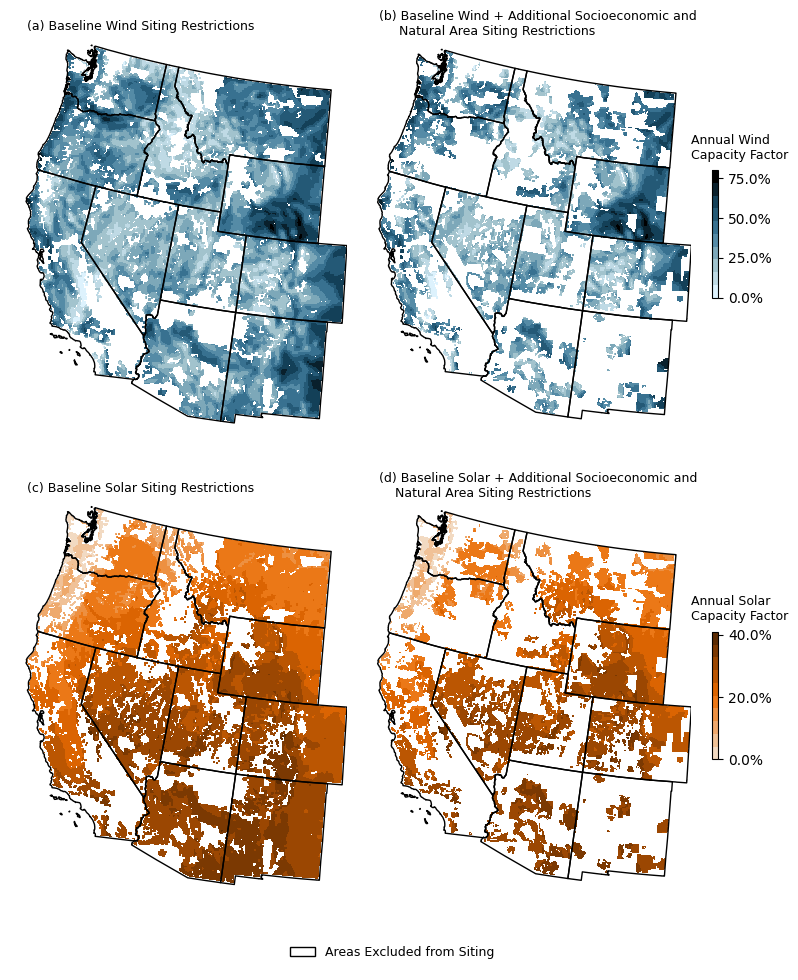

In [5]:
height = 10
width = 8

fig = plt.figure()
fig.set_figheight(height)
fig.set_figwidth(width)

spec = GridSpec(ncols=2, 
                nrows=3,
                width_ratios=[.45, .55], 
                wspace=-.5,
                hspace=0.1,
                height_ratios=[.5 ,.5, .03])


ax_1a =fig.add_subplot(spec[0,0])
ax_1b =fig.add_subplot(spec[0,1])

ax_2a =fig.add_subplot(spec[1,0])
ax_2b =fig.add_subplot(spec[1,1])

ax_leg = fig.add_subplot(spec[2,:])

raster_cmap = ListedColormap(["white", "navy"])
cmap = LinearSegmentedColormap.from_list("", [ "#DDF2FD", "#9BBEC8",'#427D9D','#164863' ,'black'], 10)
solar_cmap = LinearSegmentedColormap.from_list("", [ '#f2dac2',"#eb6c02", '#5c2b02'], 10)

wind_cmap = 'YlGn'
wind_cmap=cmap
exclusion_patch = mpatches.Patch(facecolor='white', edgecolor='black', label='Areas Excluded from Siting')

wind_suit = os.path.join(land_area_raster_dir, 'gridcerf_wind_suitability_100m_hubheight.tif')
ax = ax_1a
with rasterio.open(wind_suit) as src2:
    data2 = src2.read(1, masked=True)
    data2 = np.where(data2 == 1, 1, np.nan)
    with rasterio.open(wind_potential_path) as src1:
        data1 = src1.read(1, masked=True) 
        data1 = data1

        f1 = show(data1, transform=src1.transform, ax=ax, cmap=wind_cmap)
        show(data2, transform=src2.transform, ax=ax, cmap=raster_cmap)
        wecc_shp.boundary.plot(ax=ax, color = 'black', lw=1)
        ax.set_axis_off();

ax = ax_1b
exclusion_list = [base_wind_exc_path, dac_raster_path, farm_raster_path, env_1_1km_path]
with rasterio.open(wind_potential_path) as src1:
    data1 = src1.read(1, masked=True) 
    f1 = show(data1, transform=src1.transform, ax=ax, cmap=wind_cmap)
    for f in exclusion_list:
        with rasterio.open(f) as src2:
            data2 = src2.read(1, masked=True)
            data2 = np.where(data2 == 1, 1, np.nan)
            show(data2, transform=src2.transform, ax=ax, cmap=raster_cmap)
    wecc_shp.boundary.plot(ax=ax, color = 'black', lw=1)
    ax.set_axis_off();
    norm = mpl.colors.Normalize(vmin=0, vmax=.64)
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=wind_cmap),
                ax=ax, orientation='vertical', label='', shrink=.3, pad=.05)
    cbar.ax.set_yticklabels(["{:.1%}".format(i) for i in cbar.get_ticks()]) # set ticks of your format

solar_suit = os.path.join(land_area_raster_dir, f'gridcerf_solar_pv_suitability.tif')
solar_potential_path = os.path.join(land_area_raster_dir, 'solar_2050_rcp85_potential.tif')
ax = ax_2a
with rasterio.open(solar_suit) as src2:
    data2 = src2.read(1, masked=True)
    data2 = np.where(data2 == 1, 1, np.nan)
    show(data2, transform=src2.transform, ax=ax, cmap=raster_cmap)
    with rasterio.open(solar_potential_path) as src1:
        data1 = src1.read(1, masked=True) 
        f1 = show(data1, transform=src1.transform, ax=ax, cmap=solar_cmap)
        show(data2, transform=src2.transform, ax=ax, cmap=raster_cmap)
        wecc_shp.boundary.plot(ax=ax, color = 'black', lw=1)
        ax.set_axis_off();

ax = ax_2b
exclusion_list = [solar_suit, dac_raster_path, farm_raster_path, env_1_1km_path]
with rasterio.open(solar_potential_path) as src1:
    data1 = src1.read(1, masked=True)
    f1 = show(data1, transform=src1.transform, ax=ax, cmap=solar_cmap)
    for f in exclusion_list:
        with rasterio.open(f) as src2:
            data2 = src2.read(1, masked=True)
            data2 = np.where(data2 == 1, 1, np.nan)
            show(data2, transform=src2.transform, ax=ax, cmap=raster_cmap)
    wecc_shp.boundary.plot(ax=ax, color = 'black', lw=1)
    ax.set_axis_off();
    norm = mpl.colors.Normalize(vmin=0, vmax=.41)
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=solar_cmap),
                ax=ax, orientation='vertical', label='', shrink=.3, pad=.05)
    cbar.ax.set_yticklabels(["{:.1%}".format(i) for i in cbar.get_ticks()]) # set ticks of your format


ax_leg.legend(handles=[exclusion_patch], 
           fontsize=9, 
           loc='lower center',
             frameon=False)
ax_leg.set_axis_off();
ax_1a.annotate('(a) Baseline Wind Siting Restrictions' , xy=(-2.35e6, 1.65e6), ha='left', size=9)
ax_1b.annotate('Annual Wind\nCapacity Factor' , xy=(-.505e6, .92e6), ha='left', size=9)
ax_1b.annotate('(b) Baseline Wind + Additional Socioeconomic and \n     Natural Area Siting Restrictions' , xy=(-2.35e6, 1.65e6), ha='left', size=9)
ax_2a.annotate('(c) Baseline Solar Siting Restrictions' , xy=(-2.35e6, 1.65e6), ha='left', size=9)
ax_2b.annotate('Annual Solar\nCapacity Factor' , xy=(-.505e6, .92e6), ha='left', size=9)
ax_2b.annotate('(d) Baseline Solar + Additional Socioeconomic and \n    Natural Area Siting Restrictions' , xy=(-2.35e6, 1.65e6), ha='left', size=9)
spec.tight_layout(fig)
plt.savefig(os.path.join(figure_dir, 'fig_5_suitability_map.png'), dpi=300)